In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, BatchNormalization
from keras.layers import Merge, Concatenate, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import isolearn_keras as iso

from aparent_losses import *

from scipy.stats import pearsonr

import sklearn.linear_model as sklinear
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import pearsonr


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Load apadb data
apadb_dict = pickle.load(open('apa_apadb_data.pickle', 'rb'))
apadb_df = apadb_dict['apadb_df']

#Filter on pairwise read count
apadb_min_pair_count = 1000

apadb_keep_index = np.nonzero(np.ravel(apadb_df.pair_count.values) >= apadb_min_pair_count)[0]
apadb_df = apadb_df.iloc[apadb_keep_index]

print('APADB size = ' + str(len(apadb_df)))

#Take only pooled datapoints
apadb_df = apadb_df.query("tissue == 'pooled'").copy()

#Shuffle APADB dataframe

shuffle_index = np.arange(len(apadb_df))
np.random.shuffle(shuffle_index)

apadb_df = apadb_df.iloc[shuffle_index].copy().reset_index(drop=True)

print('Total size = ' + str(len(apadb_df)))

#Split into training and test data

valid_set_size = 0.05
test_set_size = 0.05

apadb_index = np.arange(len(apadb_df), dtype=np.int)

apadb_train_index = apadb_index[:-int(len(apadb_df) * (valid_set_size + test_set_size))]
apadb_valid_index = apadb_index[apadb_train_index.shape[0]:-int(len(apadb_df) * valid_set_size)]
apadb_test_index = apadb_index[apadb_train_index.shape[0] + apadb_valid_index.shape[0]:]

print('Training set size = ' + str(apadb_train_index.shape[0]))
print('Validation set size = ' + str(apadb_valid_index.shape[0]))
print('Test set size = ' + str(apadb_test_index.shape[0]))


APADB size = 6286
Total size = 3415
Training set size = 3074
Validation set size = 171
Test set size = 170


In [68]:

apadb_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {'df' : apadb_df},
        batch_size=32,
        inputs = [
            {
                'id' : 'seq_prox',
                'source' : 'df',
                'source_type' : 'dataframe',
                'extractor' : iso.SequenceExtractor('wide_seq_ext_prox', start_pos=105, end_pos=105 + 205),
                'encoder' : iso.OneHotEncoder(seq_length=205),
                'dim' : (205, 4, 1),
                'sparsify' : False
            },
            {
                'id' : 'seq_dist',
                'source' : 'df',
                'source_type' : 'dataframe',
                'extractor' : iso.SequenceExtractor('wide_seq_ext_dist', start_pos=105, end_pos=105 + 205),
                'encoder' : iso.OneHotEncoder(seq_length=205),
                'dim' : (205, 4, 1),
                'sparsify' : False
            },
            {
                'id' : 'start_prox',
                'source' : 'df',
                'source_type' : 'dataframe',
                'extractor' : lambda row, index: row['rel_start_prox'],
                'transformer' : None,
                'dim' : (1,),
                'sparsify' : False
            },
            {
                'id' : 'end_prox',
                'source' : 'df',
                'source_type' : 'dataframe',
                'extractor' : lambda row, index: row['rel_end_prox'],
                'transformer' : None,
                'dim' : (1,),
                'sparsify' : False
            },
            {
                'id' : 'start_dist',
                'source' : 'df',
                'source_type' : 'dataframe',
                'extractor' : lambda row, index: row['rel_start_dist'],
                'transformer' : None,
                'dim' : (1,),
                'sparsify' : False
            },
            {
                'id' : 'end_dist',
                'source' : 'df',
                'source_type' : 'dataframe',
                'extractor' : lambda row, index: row['rel_end_dist'],
                'transformer' : None,
                'dim' : (1,),
                'sparsify' : False
            },
            {
                'id' : 'site_distance',
                'source' : 'df',
                'source_type' : 'dataframe',
                'extractor' : lambda row, index: np.log(np.abs(row['cut_start_dist'] - row['cut_start_prox'])),
                'transformer' : None,
                'dim' : (1,),
                'sparsify' : False
            },
            {
                'id' : 'total_count',
                'source' : 'df',
                'source_type' : 'dataframe',
                'extractor' : lambda row, index: row['pair_count'],
                'transformer' : None,
                'dim' : (1,),
                'sparsify' : False
            },
            {
                'id' : 'prox_count',
                'source' : 'df',
                'source_type' : 'dataframe',
                'extractor' : lambda row, index: row['count_prox'],
                'transformer' : None,
                'dim' : (1,),
                'sparsify' : False
            },
            {
                'id' : 'dist_count',
                'source' : 'df',
                'source_type' : 'dataframe',
                'extractor' : lambda row, index: row['count_dist'],
                'transformer' : None,
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'dummy_output',
                'source_type' : 'zeros',
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [],
        shuffle = True
    ) for gen_id, idx in [('train', apadb_train_index), ('valid', apadb_valid_index), ('test', apadb_test_index)]
}

In [69]:
#Keras loss functions

def get_sample_weights(counts, batch_size=32) :
    weights = K.log(1.0 + counts) / K.log(2.0)
    
    return tf.ones((batch_size,))#(weights / np.sum(weights)) * batch_size
    #return (weights / K.sum(weights)) * batch_size

def cross_entropy(inputs) :
    y_true, y_pred, counts = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    sample_weights = get_sample_weights(counts)
    
    return -K.sum(y_true * K.log(y_pred), axis=-1) * sample_weights

def mean_cross_entropy(inputs) :
    y_true, y_pred, counts = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    sample_weights = get_sample_weights(counts)
    
    return -K.mean(y_true * K.log(y_pred), axis=-1) * sample_weights

def sigmoid_entropy(inputs) :
    y_true, y_pred, counts = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    sample_weights = get_sample_weights(counts)
    
    return -K.sum(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred), axis=-1) * sample_weights

def mean_sigmoid_entropy(inputs) :
    y_true, y_pred, counts = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    sample_weights = get_sample_weights(counts)
    
    return -K.mean(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred), axis=-1) * sample_weights

def kl_divergence(inputs) :
    y_true, y_pred, counts = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
    sample_weights = get_sample_weights(counts)
    
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1) * sample_weights

def mean_kl_divergence(inputs) :
    y_true, y_pred, counts = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
    sample_weights = get_sample_weights(counts)
    
    return K.mean(y_true * K.log(y_true / y_pred), axis=-1) * sample_weights

def sigmoid_kl_divergence(inputs) :
    y_true, y_pred, counts = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
    sample_weights = get_sample_weights(counts)
    
    return K.sum(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1) * sample_weights

def mean_sigmoid_kl_divergence(inputs) :
    y_true, y_pred, counts = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
    sample_weights = get_sample_weights(counts)
    
    return K.mean(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1) * sample_weights

def symmetric_kl_divergence(inputs) :
    y_true, y_pred, counts = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
    sample_weights = get_sample_weights(counts)
    
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1) * sample_weights + K.sum(y_pred * K.log(y_pred / y_true), axis=-1) * sample_weights

def mean_symmetric_kl_divergence(inputs) :
    y_true, y_pred, counts = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
    sample_weights = get_sample_weights(counts)
    
    return K.mean(y_true * K.log(y_true / y_pred), axis=-1) * sample_weights + K.mean(y_pred * K.log(y_pred / y_true), axis=-1) * sample_weights

def symmetric_sigmoid_kl_divergence(inputs) :
    y_true, y_pred, counts = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
    sample_weights = get_sample_weights(counts)
    
    return K.sum(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1) * sample_weights + K.sum(y_pred * K.log(y_pred / y_true) + (1.0 - y_pred) * K.log((1.0 - y_pred) / (1.0 - y_true)), axis=-1) * sample_weights

def mean_symmetric_sigmoid_kl_divergence(inputs) :
    y_true, y_pred, counts = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
    sample_weights = get_sample_weights(counts)
    
    return K.mean(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1) * sample_weights + K.mean(y_pred * K.log(y_pred / y_true) + (1.0 - y_pred) * K.log((1.0 - y_pred) / (1.0 - y_true)), axis=-1) * sample_weights

In [70]:
seq_prox = np.concatenate([apadb_gens['train'][i][0][0] for i in range(len(apadb_gens['train']))], axis=0)
seq_dist = np.concatenate([apadb_gens['train'][i][0][1] for i in range(len(apadb_gens['train']))], axis=0)

start_prox = np.concatenate([apadb_gens['train'][i][0][2] for i in range(len(apadb_gens['train']))], axis=0)
end_prox = np.concatenate([apadb_gens['train'][i][0][3] for i in range(len(apadb_gens['train']))], axis=0)
start_dist = np.concatenate([apadb_gens['train'][i][0][4] for i in range(len(apadb_gens['train']))], axis=0)
end_dist = np.concatenate([apadb_gens['train'][i][0][5] for i in range(len(apadb_gens['train']))], axis=0)

site_distance = np.concatenate([apadb_gens['train'][i][0][6] for i in range(len(apadb_gens['train']))], axis=0)

total_count = np.concatenate([apadb_gens['train'][i][0][7] for i in range(len(apadb_gens['train']))], axis=0)
prox_count = np.concatenate([apadb_gens['train'][i][0][8] for i in range(len(apadb_gens['train']))], axis=0)
dist_count = np.concatenate([apadb_gens['train'][i][0][9] for i in range(len(apadb_gens['train']))], axis=0)


In [71]:
#Load model

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'aparent_plasmid_iso_cut_distalpas_large_lessdropout_all_libs_no_sampleweights.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

model = load_model(model_path)

#Generate fake model inputs for library biases (irrelevant for APADB)
fake_lib = np.zeros((seq_prox.shape[0], 13))
fake_distal_pas = np.ones((seq_prox.shape[0], 1))

#Predict prox/dist scores
_, cut_pred_prox = model.predict(x=[seq_prox, fake_lib, fake_distal_pas])
_, cut_pred_dist = model.predict(x=[seq_dist, fake_lib, fake_distal_pas])



/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [72]:
#Calculate log odds isoform scores

prox_score, dist_score = [], []
for i in range(seq_prox.shape[0]) :
    
    iso_pred_prox = np.sum(cut_pred_prox[i, int(start_prox[i]): int(end_prox[i]) + 1], axis=-1)
    iso_pred_dist = np.sum(cut_pred_dist[i, int(start_dist[i]): int(end_dist[i]) + 1], axis=-1)
    
    prox_score.append(np.log(iso_pred_prox / (1.0 - iso_pred_prox)))
    dist_score.append(np.log(iso_pred_dist / (1.0 - iso_pred_dist)))

prox_score, dist_score = np.array(prox_score), np.array(dist_score)

In [73]:
#Create APADB regression features: prox_score, dist_score & site_distance

X = np.zeros((seq_prox.shape[0], 3))
X[:, 0] = prox_score[:]
X[:, 1] = dist_score[:]
X[:, 2] = site_distance[:, 0]

#Create APADB regression targets: log odds of prox_count / (prox_count + dist_count), with laplace smoothing
laplace_smoothing = 0.0

#iso_true = (prox_count + laplace_smoothing) / (prox_count + dist_count + 2 * laplace_smoothing)
iso_true = np.ravel(prox_count / (prox_count + dist_count))
logodds_true = np.log(iso_true / (1.0 - iso_true))


APADB log isoform prediction R^2 (Cross-Val) = 0.7052778845576745
Accuracy = 0.8948567708333334


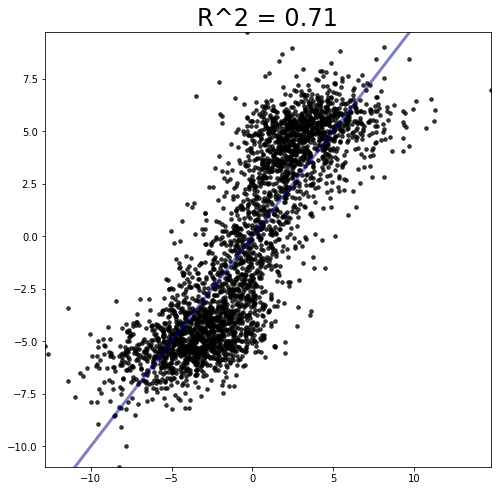

In [79]:
#Run linear regression cross-validation on APADB features, extract regression weights

def fit_loocv_model(X, y, l2_lambda=None) :
    lr = sklinear.LinearRegression()
    if l2_lambda is not None :
        lr = sklinear.Ridge(alpha=l2_lambda)

    y_hat = cross_val_predict(lr, X, y, cv=X.shape[0])

    SSE = (y - y_hat).T.dot(y - y_hat)
    y_average = np.average(y, axis=0)
    SStot = (y - y_average).T.dot(y - y_average)
    rsquare = 1.0 - (SSE / SStot)

    accuracy = float(np.count_nonzero(np.sign(y) == np.sign(y_hat))) / float(X.shape[0])
    
    lr.fit(X, y)
    
    return y_hat, rsquare, accuracy, (lr.coef_, lr.intercept_)

def predict_linear_model(X, w, w_0) :
    return X.dot(w) + w_0

def predict_logistic_model(X, w, w_0) :
    score = X.dot(w) + w_0
    return 1. / (1. + np.exp(-score))


logodds_pred, rsquare, accuracy, weight_bundle = fit_loocv_model(X, logodds_true, l2_lambda=None)

print("APADB log isoform prediction R^2 (Cross-Val) = " + str(rsquare))
print("Accuracy = " + str(accuracy))

f = plt.figure(figsize=(8, 8))

plt.scatter(logodds_pred, logodds_true, s = np.pi * (2 * np.ones(1))**2, alpha=0.75, color='black')
min_x = max(np.min(logodds_pred), np.min(logodds_true))
max_x = min(np.max(logodds_pred), np.max(logodds_true))
min_y = max(np.min(logodds_pred), np.min(logodds_true))
max_y = min(np.max(logodds_pred), np.max(logodds_true))
plt.plot([min_x, max_x], [min_y, max_y], alpha=0.5, color='darkblue', linewidth=3)

plt.axis([np.min(logodds_pred), np.max(logodds_pred), np.min(logodds_true), np.max(logodds_true)])
plt.title('R^2 = ' + str(round(rsquare, 2)), fontsize=24)
plt.show()
plt.close()


In [93]:
#Inject weights into new keras model

def load_tuned_model() :
    
    #APARENT parameters
    seq_length = 205
    seq_input_shape = (205, 4, 1)
    lib_input_shape = (13,)
    distal_pas_shape = (1,)
    num_outputs_iso = 1
    num_outputs_cut = 206
    
    
    #Shared model definition
    layer_1 = Conv2D(96, (8, 4), padding='valid', activation='relu', name='aparent_conv_1')
    layer_1_pool = MaxPooling2D(pool_size=(2, 1))
    layer_2 = Conv2D(128, (6, 1), padding='valid', activation='relu', name='aparent_conv_2')
    layer_dense = Dense(512, activation='relu', name='aparent_dense_1')
    layer_drop = Dropout(0.1)
    layer_dense2 = Dense(256, activation='relu', name='aparent_dense_2')
    layer_drop2 = Dropout(0.1)

    def shared_model(seq_input, distal_pas_input) :
        return layer_drop2(
                    layer_dense2(
                        layer_drop(
                            layer_dense(
                                Concatenate()([
                                    Flatten()(
                                        layer_2(
                                            layer_1_pool(
                                                layer_1(
                                                    seq_input
                                                )
                                            )
                                        )
                                    ),
                                    distal_pas_input
                                ])
                            )#, training=False
                        )
                    )#, training=False
                )

    
    #Plasmid model definition
    seq_prox = Input(shape=seq_input_shape)
    seq_dist = Input(shape=seq_input_shape)
    start_prox = Input(shape=(1,))
    end_prox = Input(shape=(1,))
    start_dist = Input(shape=(1,))
    end_dist = Input(shape=(1,))
    site_distance = Input(shape=(1,))
    
    lib_input = Input(shape=lib_input_shape)
    distal_pas_input = Input(shape=distal_pas_shape)

    #Outputs
    prox_out_shared = Concatenate()([shared_model(seq_prox, distal_pas_input), lib_input])
    dist_out_shared = Concatenate()([shared_model(seq_dist, distal_pas_input), lib_input])
    
    cut_layer = Dense(num_outputs_cut, activation='softmax', kernel_initializer='zeros', name='aparent_cut_dense')

    prox_cut = cut_layer(prox_out_shared)
    dist_cut = cut_layer(dist_out_shared)
    
    prox_cut_and_start_end = Lambda(lambda c: K.concatenate(c, axis=-1))([prox_cut, start_prox, end_prox])
    dist_cut_and_start_end = Lambda(lambda c: K.concatenate(c, axis=-1))([dist_cut, start_dist, end_dist])
    
    score_layer = Lambda(lambda c: K.map_fn(lambda s: K.sum(s[K.cast(s[-2], dtype='int32'): K.cast(s[-1], dtype='int32') + 1], axis=-1), c), output_shape=(1,))
    
    prox_iso = Reshape((1,))(score_layer(prox_cut_and_start_end))
    dist_iso = Reshape((1,))(score_layer(dist_cut_and_start_end))
    
    prox_score = Lambda(lambda c: K.log(c / (1.0 - c)), output_shape=(1,))(prox_iso)
    dist_score = Lambda(lambda c: K.log(c / (1.0 - c)), output_shape=(1,))(dist_iso)
    
    regression_in = Concatenate(axis=-1)([prox_score, dist_score, site_distance])
    regression_out = Dense(1, activation='sigmoid', kernel_initializer='zeros', name='apadb_layer')(regression_in)
    
    norm_prox_cut = Lambda(lambda c: c[:, :-1] / K.expand_dims(K.sum(c[:, :-1], axis=-1), axis=-1))(prox_cut)
    norm_dist_cut = Lambda(lambda c: c[:, :-1] / K.expand_dims(K.sum(c[:, :-1], axis=-1), axis=-1))(dist_cut)
    
    apadb_model = Model(
        inputs=[
            seq_prox,
            seq_dist,
            start_prox,
            end_prox,
            start_dist,
            end_dist,
            site_distance,
            
            lib_input,
            distal_pas_input
        ],
        outputs=[
            regression_out,
            norm_prox_cut,
            norm_dist_cut
        ]
    )

    return apadb_model

apadb_model = load_tuned_model()

In [99]:
#Load model and set weights

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'aparent_plasmid_iso_cut_distalpas_large_lessdropout_all_libs_no_sampleweights.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

saved_model = load_model(model_path)

apadb_model.get_layer('aparent_conv_1').set_weights(saved_model.get_layer('conv2d_1').get_weights())

apadb_model.get_layer('aparent_conv_2').set_weights(saved_model.get_layer('conv2d_2').get_weights())

apadb_model.get_layer('aparent_dense_1').set_weights(saved_model.get_layer('dense_1').get_weights())

apadb_model.get_layer('aparent_dense_2').set_weights(saved_model.get_layer('dense_2').get_weights())

apadb_model.get_layer('aparent_cut_dense').set_weights(saved_model.get_layer('dense_3').get_weights())

apadb_model.get_layer('apadb_layer').set_weights([weight_bundle[0].reshape(-1, 1), np.array([weight_bundle[1]])])

#Dummy compile
opt = keras.optimizers.SGD(lr=0.1)
apadb_model.compile(loss='mean_squared_error', optimizer=opt)


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [104]:
#...Or load already built APADB model

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'aparent_apadb_fitted.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

apadb_model = load_model(model_path)


In [105]:
#Test integrated APADB keras model

#Generate fake model inputs for library biases (irrelevant for APADB)
fake_lib = np.zeros((seq_prox.shape[0], 13))
fake_distal_pas = np.ones((seq_prox.shape[0], 1))

#Predict prox/dist scores
iso_pred, cut_pred_prox, cut_pred_dist = apadb_model.predict(
    x=[
        seq_prox,
        seq_dist,
        start_prox,
        end_prox,
        start_dist,
        end_dist,
        site_distance,
        fake_lib,
        fake_distal_pas
    ]
)


APADB log isoform prediction R^2 (Cross-Val) = 0.706092426127064
Accuracy = 0.8948567708333334


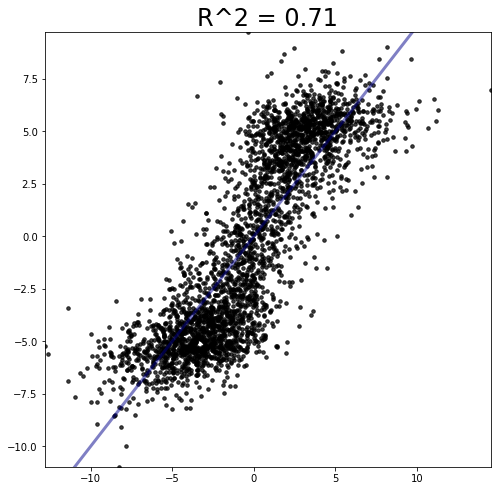

In [106]:
logodds_pred = np.ravel(np.log(iso_pred / (1.0 - iso_pred)))

r_val, _ = pearsonr(logodds_pred, logodds_true)

print("APADB log isoform prediction R^2 (Cross-Val) = " + str(r_val * r_val))
print("Accuracy = " + str(accuracy))

f = plt.figure(figsize=(8, 8))

plt.scatter(logodds_pred, logodds_true, s = np.pi * (2 * np.ones(1))**2, alpha=0.75, color='black')
min_x = max(np.min(logodds_pred), np.min(logodds_true))
max_x = min(np.max(logodds_pred), np.max(logodds_true))
min_y = max(np.min(logodds_pred), np.min(logodds_true))
max_y = min(np.max(logodds_pred), np.max(logodds_true))
plt.plot([min_x, max_x], [min_y, max_y], alpha=0.5, color='darkblue', linewidth=3)

plt.axis([np.min(logodds_pred), np.max(logodds_pred), np.min(logodds_true), np.max(logodds_true)])
plt.title('R^2 = ' + str(round(rsquare, 2)), fontsize=24)
plt.show()
plt.close()

In [103]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, 'aparent_apadb_fitted.h5')
apadb_model.save(model_path)
print('Saved trained model at %s ' % model_path)


Saved trained model at /home/jlinder2/apa/saved_models/aparent_apadb_fitted.h5 
